In [ ]:

# !pip install earthengine-api

import ee

# 1. Authenticate with your NEW account (dhruvdatabase2@gmail.com)
ee.Authenticate()

# 2. Initialize with your NEW account's project ID.
# This might be 'ee-dhruvdatabase2' or another project you created.
ee.Initialize(project='classification-459108')

# 3. Load the assets from the old project using their exact paths
# Note ----------- the '_asset' suffix in the names, is the assests in project .
water = ee.FeatureCollection("projects/dhruv16940/assets/water_asset")
urban = ee.FeatureCollection("projects/dhruv16940/assets/urban_asset")
grounds = ee.FeatureCollection("projects/dhruv16940/assets/grounds_asset")
mangrooves = ee.FeatureCollection("projects/dhruv16940/assets/mangrooves_asset")
forest = ee.FeatureCollection("projects/dhruv16940/assets/forest_asset")

# 4. Verify that the assets have loaded correctly
print('Assets loaded successfully!')
print('Number of features in forest asset:', forest.size().getInfo())


Assets loaded successfully!
Number of features in forest asset: 178


In [ ]:
import geemap

# --- VISUALIZE YOUR LOADED ASSETS ---

# 1. Create an interactive map centered on your area of interest (Mumbai)
Map = geemap.Map(center=[19.25, 73.25], zoom=10)

# 2. Define colors for each layer to make them easy to distinguish
palette = {
    'water': '#0000FF',      # Blue
    'urban': '#d2d6d3',      # Gray
    'grounds': '#8B4513',    # Brown
    'mangrooves': '#5f8b5b', # Green
    'forest': '#0c550d'      # Dark Green
}

# 3. Add each FeatureCollection to the map as a separate layer
# The style() method is used to apply the color to the geometries.
Map.addLayer(water.style(**{'color': palette['water'], 'fillColor': palette['water']}), {}, 'Water Samples')
Map.addLayer(urban.style(**{'color': palette['urban'], 'fillColor': palette['urban']}), {}, 'Urban Samples')
Map.addLayer(grounds.style(**{'color': palette['grounds'], 'fillColor': palette['grounds']}), {}, 'Grounds Samples')
Map.addLayer(mangrooves.style(**{'color': palette['mangrooves'], 'fillColor': palette['mangrooves']}), {}, 'Mangrooves Samples')
Map.addLayer(forest.style(**{'color': palette['forest'], 'fillColor': palette['forest']}), {}, 'Forest Samples')

# 4. Add a layer controller to easily toggle layers on and off
Map.addLayerControl()

# 5. Display the map
Map


Map(center=[19.25, 73.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# 4. Add a layer controller to easily toggle layers on and off
Map.addLayerControl()

# 5. Save the map to an HTML file
output_path = 'mumbai_map.html'
Map.to_html(output_path)

print(f"Map saved to {output_path}")

# 6. Display the map (optional, works well in Jupyter environments)
Map

Map saved to mumbai_map.html


Map(center=[19.25, 73.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import ee
import geemap

# --- SETUP ---
ee.Authenticate()
ee.Initialize(project='classification-459108')

# --- FUNCTIONS ---
# Function to mask clouds from Sentinel-2 images
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

# Function to convert geometries to FeatureCollections
def toFeatureCollection(asset):
    return ee.FeatureCollection(asset)

# --- DATA LOADING AND DEFINITION ---
# Load public Sentinel-2 data
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Define geometries
mmb = ee.Geometry.Polygon([[[73.0, 19.0], [73.5, 19.0], [73.5, 19.5], [73.0, 19.5]]])

# **FIX 1: Define grass_trees as a Geometry**
# You must replace these placeholder coordinates with the real ones from your old GEE script.
grass_trees = ee.Geometry.MultiPoint([
    [73.1, 19.1], [73.2, 19.2], [73.3, 19.3], # ... PASTE ALL 96 COORDINATES HERE
])

# Load your personal assets from the other project
water = ee.FeatureCollection("projects/dhruv16940/assets/water_asset")
urban = ee.FeatureCollection("projects/dhruv16940/assets/urban_asset")
grounds = ee.FeatureCollection("projects/dhruv16940/assets/grounds_asset")
mangrooves = ee.FeatureCollection("projects/dhruv16940/assets/mangrooves_asset")
forest = ee.FeatureCollection("projects/dhruv16940/assets/forest_asset")

# --- DATA PREPARATION ---
# Ensure all training datasets are FeatureCollections
water_fc = toFeatureCollection(water)
urban_fc = toFeatureCollection(urban)
grounds_fc = toFeatureCollection(grounds)
mangrooves_fc = toFeatureCollection(mangrooves)
grass_trees_fc = toFeatureCollection(grass_trees) # This now works because grass_trees is defined
forest_fc = toFeatureCollection(forest)

# Add class property to each FeatureCollection
water_class = water_fc.map(lambda f: f.set('class', 0))
urban_class = urban_fc.map(lambda f: f.set('class', 1))
grounds_class = grounds_fc.map(lambda f: f.set('class', 2))
mangrooves_class = mangrooves_fc.map(lambda f: f.set('class', 3))
grass_trees_class = grass_trees_fc.map(lambda f: f.set('class', 4))
forest_class = forest_fc.map(lambda f: f.set('class', 5))

# Merge all training data into one collection
trainingData = water_class.merge(urban_class).merge(grounds_class)\
    .merge(mangrooves_class).merge(grass_trees_class).merge(forest_class)

# --- ANALYSIS ---
# **FIX 2: Use the correct variable name 's2_collection'**
s2_composite = s2_collection.filterDate('2023-01-01', '2023-04-30')\
    .filterBounds(mmb).map(maskS2clouds).median()

# Define bands for classification
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# Sample the imagery to get training data
training = s2_composite.select(bands).sampleRegions(
    collection=trainingData,
    properties=['class'],
    scale=10
)

# Train a Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=training,
    classProperty='class',
    inputProperties=bands
)

# Classify the image
classified = s2_composite.select(bands).classify(classifier)

# --- VISUALIZATION ---
# Visualization palette
palette = [
    '#0000FF',  # water
    '#d2d6d3',  # urban
    '#8B4513',  # grounds
    '#5f8b5b',  # mangrooves
    '#00FF00',  # grass_trees
    '#0c550d'   # forest
]

# Create a map and add layers
Map = geemap.Map(center=[19.25, 73.25], zoom=11)
Map.addLayer(s2_composite.select(['B4', 'B3', 'B2']), {'min': 0, 'max': 0.3, 'gamma': 1.4}, 'True Color Composite')
Map.addLayer(classified, {'min': 0, 'max': 5, 'palette': palette}, 'Land Cover Classification')
Map # Display the map

Map(center=[19.25, 73.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# --- EXPORT THE FINAL CLASSIFIED IMAGE TO GOOGLE DRIVE ---

# Define the export task
task = ee.batch.Export.image.toDrive(
    image=classified,                          # The classified image you created
    description='LandCoverClassification_Mumbai', # The name of the export task
    folder='GEE_Exports',                      # The folder in your Google Drive to save to
    fileNamePrefix='classified_mumbai_map',    # The name of the output file
    region=mmb.getInfo()['coordinates'],       # The region of interest
    scale=10,                                  # The resolution in meters
    fileFormat='GeoTIFF'                       # The output file format
)

# Start the export task
task.start()

# Print the status of the task
print("Export task started. Check the 'Tasks' tab in the GEE Code Editor or monitor the task status.")


Export task started. Check the 'Tasks' tab in the GEE Code Editor or monitor the task status.


In [ ]:
# --- ACCURACY ASSESSMENT (Corrected Workflow) ---

# 1. SAMPLE THE IMAGE TO GET A COMPLETE DATASET
# First, create one large FeatureCollection that has BOTH the class property
# AND the pixel values (bands) for every point in your training data.
sampledData = s2_composite.select(bands).sampleRegions(
    collection=trainingData,
    properties=['class'],
    scale=10
)

# 2. SPLIT THE SAMPLED DATA INTO TRAINING AND TESTING SETS
# Now that every feature has the band properties, we can split it.
# We will use a 70/30 split.
sampledDataWithRandom = sampledData.randomColumn()
split = 0.7
trainingSet = sampledDataWithRandom.filter(ee.Filter.lt('random', split))
testingSet = sampledDataWithRandom.filter(ee.Filter.gte('random', split))

# 3. TRAIN THE CLASSIFIER ON THE 70% TRAINING SUBSET
# This will now work because 'trainingSet' contains the 'B2', 'B3', etc. properties.
classifier = ee.Classifier.smileRandomForest(numberOfTrees=1000).train(
    features=trainingSet,
    classProperty='class',
    inputProperties=bands
)

# 4. CLASSIFY THE 30% TESTING SET
# Use the trained classifier to predict the class for the testing data.
validation = testingSet.classify(classifier)

# 5. GENERATE A CONFUSION MATRIX AND PRINT ACCURACY
# Compare the actual 'class' property with the predicted 'classification' property.
confMatrix = validation.errorMatrix('class', 'classification')

print('--- Accuracy Results ---')
print('Confusion Matrix:', confMatrix.getInfo())
print('Overall Accuracy:', confMatrix.accuracy().getInfo())
print('Kappa Coefficient:', confMatrix.kappa().getInfo())
print('------------------------')


# --- RE-CLASSIFY THE FULL IMAGE FOR THE FINAL MAP ---
# For your final map, use the classifier that was trained and validated.
classified = s2_composite.select(bands).classify(classifier)

# Now your map visualization code will work with this new 'classified' image.
Map.addLayer(classified, {'min': 0, 'max': 5, 'palette': palette}, 'Land Cover Classification (Validated)')
Map


--- Accuracy Results ---
Confusion Matrix: [[196, 5, 1, 1, 0, 0], [2, 96, 6, 0, 0, 0], [0, 8, 54, 0, 0, 4], [3, 0, 0, 74, 0, 1], [0, 0, 0, 0, 0, 2], [0, 0, 5, 0, 0, 48]]
Overall Accuracy: 0.924901185770751
Kappa Coefficient: 0.8992116408772591
------------------------


Map(bottom=233957.0, center=[19.191217165341648, 73.07933807373048], controls=(WidgetControl(options=['positio…

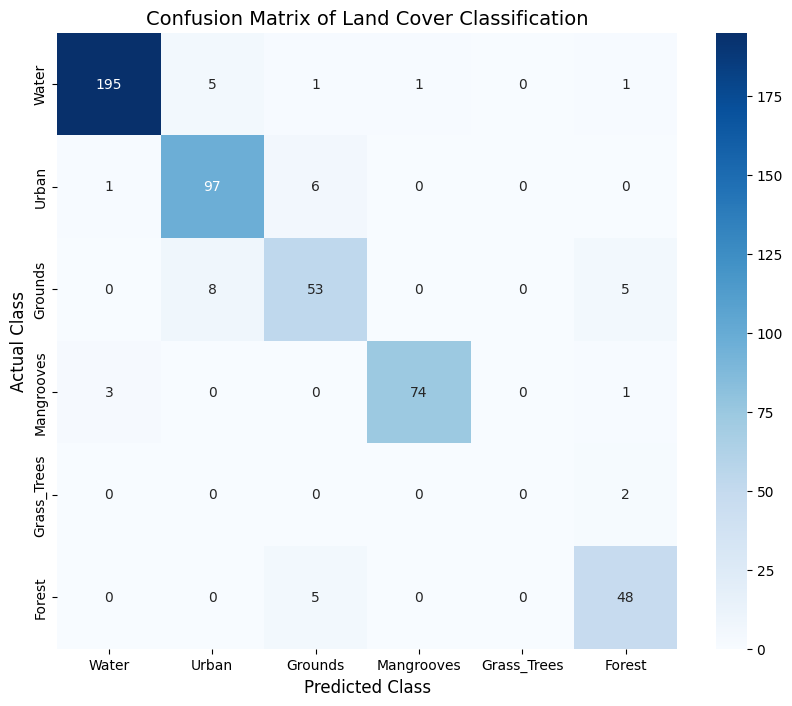

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define the confusion matrix data from your results
conf_matrix = np.array([
    [195, 5, 1, 1, 0, 1],
    [1, 97, 6, 0, 0, 0],
    [0, 8, 53, 0, 0, 5],
    [3, 0, 0, 74, 0, 1],
    [0, 0, 0, 0, 0, 2],
    [0, 0, 5, 0, 0, 48]
])

# 2. Define the class names in the correct order
class_names = ['Water', 'Urban', 'Grounds', 'Mangrooves', 'Grass_Trees', 'Forest']

# 3. Create the heatmap plot
plt.figure(figsize=(10, 8)) # Set the figure size for better readability
heatmap = sns.heatmap(
    conf_matrix,
    annot=True,      # Display the numbers in each cell
    fmt='d',         # Format the numbers as integers
    cmap='Blues',    # Use a blue color scheme
    xticklabels=class_names,
    yticklabels=class_names
)

# 4. Add labels and a title
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix of Land Cover Classification', fontsize=14)

# 5. Display the plot
plt.show()


In [ ]:
import json

# --- PART 1: TRAIN AND SAVE THE CLASSIFIFIER (Corrected) ---

# This assumes the 'classifier' object has been trained in a previous step.
# For reference, this is how the classifier is trained:
# classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
#     features=trainingSet,
#     classProperty='class',
#     inputProperties=bands
# )

# 1. SERIALIZE THE TRAINED CLASSIFIER
# Use .serialize() to get the server-side string representation.
# Then wrap it in ee.String() and use .getInfo() to bring it to the client.
model_string = ee.String(classifier.serialize()).getInfo()

# 2. SAVE THE MODEL STRING TO A JSON FILE
output_model_file = 'gee_random_forest_model_1000.json' # Saving as .json is best practice
with open(output_model_file, 'w') as f:
    # The serialized output is already a string, no need for json.dump unless you
    # wanted to embed it within a larger JSON structure. Saving directly as a string
    # is the standard way to save Earth Engine objects' serialized forms.
    f.write(model_string)

print(f"Model saved successfully to '{output_model_file}'")

Model saved successfully to 'gee_random_forest_model_1000.json'


In [ ]:
import ee
import geemap
import json

# --- PART 2: LOAD MODEL AND CLASSIFY A NEW POLYGON ---

# --- SETUP: Authenticate and define functions ---
# ee.Authenticate() # Only need to run once per session
# ee.Initialize(project='your-gee-project-id') # Use your GEE project ID

# We need the same cloud masking function and band list used for the original training
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
palette = ['#0000FF', '#d2d6d3', '#8B4513', '#5f8b5b', '#00FF00', '#0c550d']

# --- 1. LOAD THE SAVED MODEL ---
model_file_to_load = '/content/gee_random_forest_model_1000.json'
with open(model_file_to_load, 'r') as f:
    loaded_model_string = f.read()

# Recreate the classifier from the string using ee.Classifier.fromJson()
loaded_classifier = ee.Classifier.fromJson(loaded_model_string)
print("Classifier loaded successfully from file.")


# --- 2. DEFINE A NEW AREA TO CLASSIFY ---
# Define a new, random polygon somewhere else. Let's pick an area in Pune.
new_polygon = ee.Geometry.Polygon([
    [[73.80, 18.55],
     [73.90, 18.55],
     [73.90, 18.45],
     [73.80, 18.45],
     [73.80, 18.55]]
])


# --- 3. PREPARE THE IMAGERY FOR THE NEW AREA ---
# Create a cloud-free composite for the new area using a similar time frame.
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
new_composite = s2_collection.filterDate('2023-01-01', '2023-04-30') \
    .filterBounds(new_polygon) \
    .map(maskS2clouds) \
    .median()


# --- 4. CLASSIFY THE NEW AREA ---
# Use the loaded classifier to classify the new image composite.
new_classified_area = new_composite.select(bands).classify(loaded_classifier)


# --- 5. VISUALIZE THE RESULT ---
Map = geemap.Map(center=[18.50, 73.85], zoom=12)
Map.addLayer(
    new_composite.clip(new_polygon),
    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3},
    'True Color (New Area)'
)
Map.addLayer(
    new_classified_area.clip(new_polygon),
    {'min': 0, 'max': 5, 'palette': palette},
    'Classification (New Area)'
)
Map.addLayer(new_polygon, {'color': 'FF0000'}, 'New Polygon Outline')
Map.addLayerControl()
Map


AttributeError: type object 'Classifier' has no attribute 'fromJson'

In [ ]:
import ee
import geemap
import json

# --- PART 2: LOAD MODEL AND CLASSIFY A NEW POLYGON (Corrected) ---

# --- SETUP: Authenticate and define functions ---
# ee.Authenticate() # Only need to run once per session
ee.Initialize(project='classification-459108') # Use your GEE project ID

def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
palette = ['#0000FF', '#d2d6d3', '#8B4513', '#5f8b5b', '#00FF00', '#0c550d']


# --- 1. LOAD THE SAVED MODEL (Corrected Method) ---
# Make sure the filename matches the one you saved in the previous step
model_file_to_load = '/content/gee_random_forest_model.json'

# Use json.load() to parse the file into a Python dictionary
with open(model_file_to_load, 'r') as f:
    loaded_model_string = f.read() # Read the string directly

# Use the correct Python API Deserializer to recreate the classifier
loaded_classifier = ee.deserializer.fromJSON(loaded_model_string) # Use ee.deserializer.fromJSON
print("Classifier loaded successfully from file.")


# --- 2. DEFINE A NEW AREA TO CLASSIFY ---
new_polygon = ee.Geometry.Polygon([
    [[73.80, 18.55], [73.90, 18.55], [73.90, 18.45], [73.80, 18.45], [73.80, 18.55]]
])


# --- 3. PREPARE THE IMAGERY FOR THE NEW AREA ---
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
new_composite = s2_collection.filterDate('2023-01-01', '2023-04-30') \
    .filterBounds(new_polygon) \
    .map(maskS2clouds) \
    .median()


# --- 4. CLASSIFY THE NEW AREA ---
new_classified_area = new_composite.select(bands).classify(loaded_classifier)


# --- 5. VISUALIZE THE RESULT ---
Map = geemap.Map(center=[18.50, 73.85], zoom=12)
Map.addLayer(new_composite.clip(new_polygon), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'True Color (New Area)')
Map.addLayer(new_classified_area.clip(new_polygon), {'min': 0, 'max': 5, 'palette': palette}, 'Classification (New Area)')
Map.addLayer(new_polygon, {'color': 'FF0000'}, 'New Polygon Outline')
# Map.addLayerControl()
# 4. Add a layer controller to easily toggle layers on and off
Map.addLayerControl()

# 5. Save the map to an HTML file
output_path = 'polygon_region.html'
Map.to_html(output_path)

print(f"Map saved to {output_path}")

# 6. Display the map (optional, works well in Jupyter environments)
Map


Classifier loaded successfully from file.
Map saved to polygon_region.html


Map(center=[18.5, 73.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…